In [1]:
from lib.data.utils import train_data, targets, features, split_dataframe
from lib.data.plot import plot_predictions

import tensorflow as tf
from keras.callbacks import TensorBoard as TB, EarlyStopping as ES
import numpy as np
from keras.layers import LSTM, GRU, Dense
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier, CalendarSeasonality, CalendarTimeTrend
from calendar import day_name
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme(context="notebook", style="whitegrid", rc={"figure.dpi": 100})

%config InlineBackend.figure_format = 'retina'


In [2]:
df = train_data("../data", delta=True)
(df, _), val_df = split_dataframe(df, 0.1, 0.0)


array([<Axes: xlabel='date_time'>, <Axes: xlabel='date_time'>,
       <Axes: xlabel='date_time'>, <Axes: xlabel='date_time'>,
       <Axes: xlabel='date_time'>, <Axes: xlabel='date_time'>,
       <Axes: xlabel='date_time'>, <Axes: xlabel='date_time'>,
       <Axes: xlabel='date_time'>, <Axes: xlabel='date_time'>,
       <Axes: xlabel='date_time'>], dtype=object)

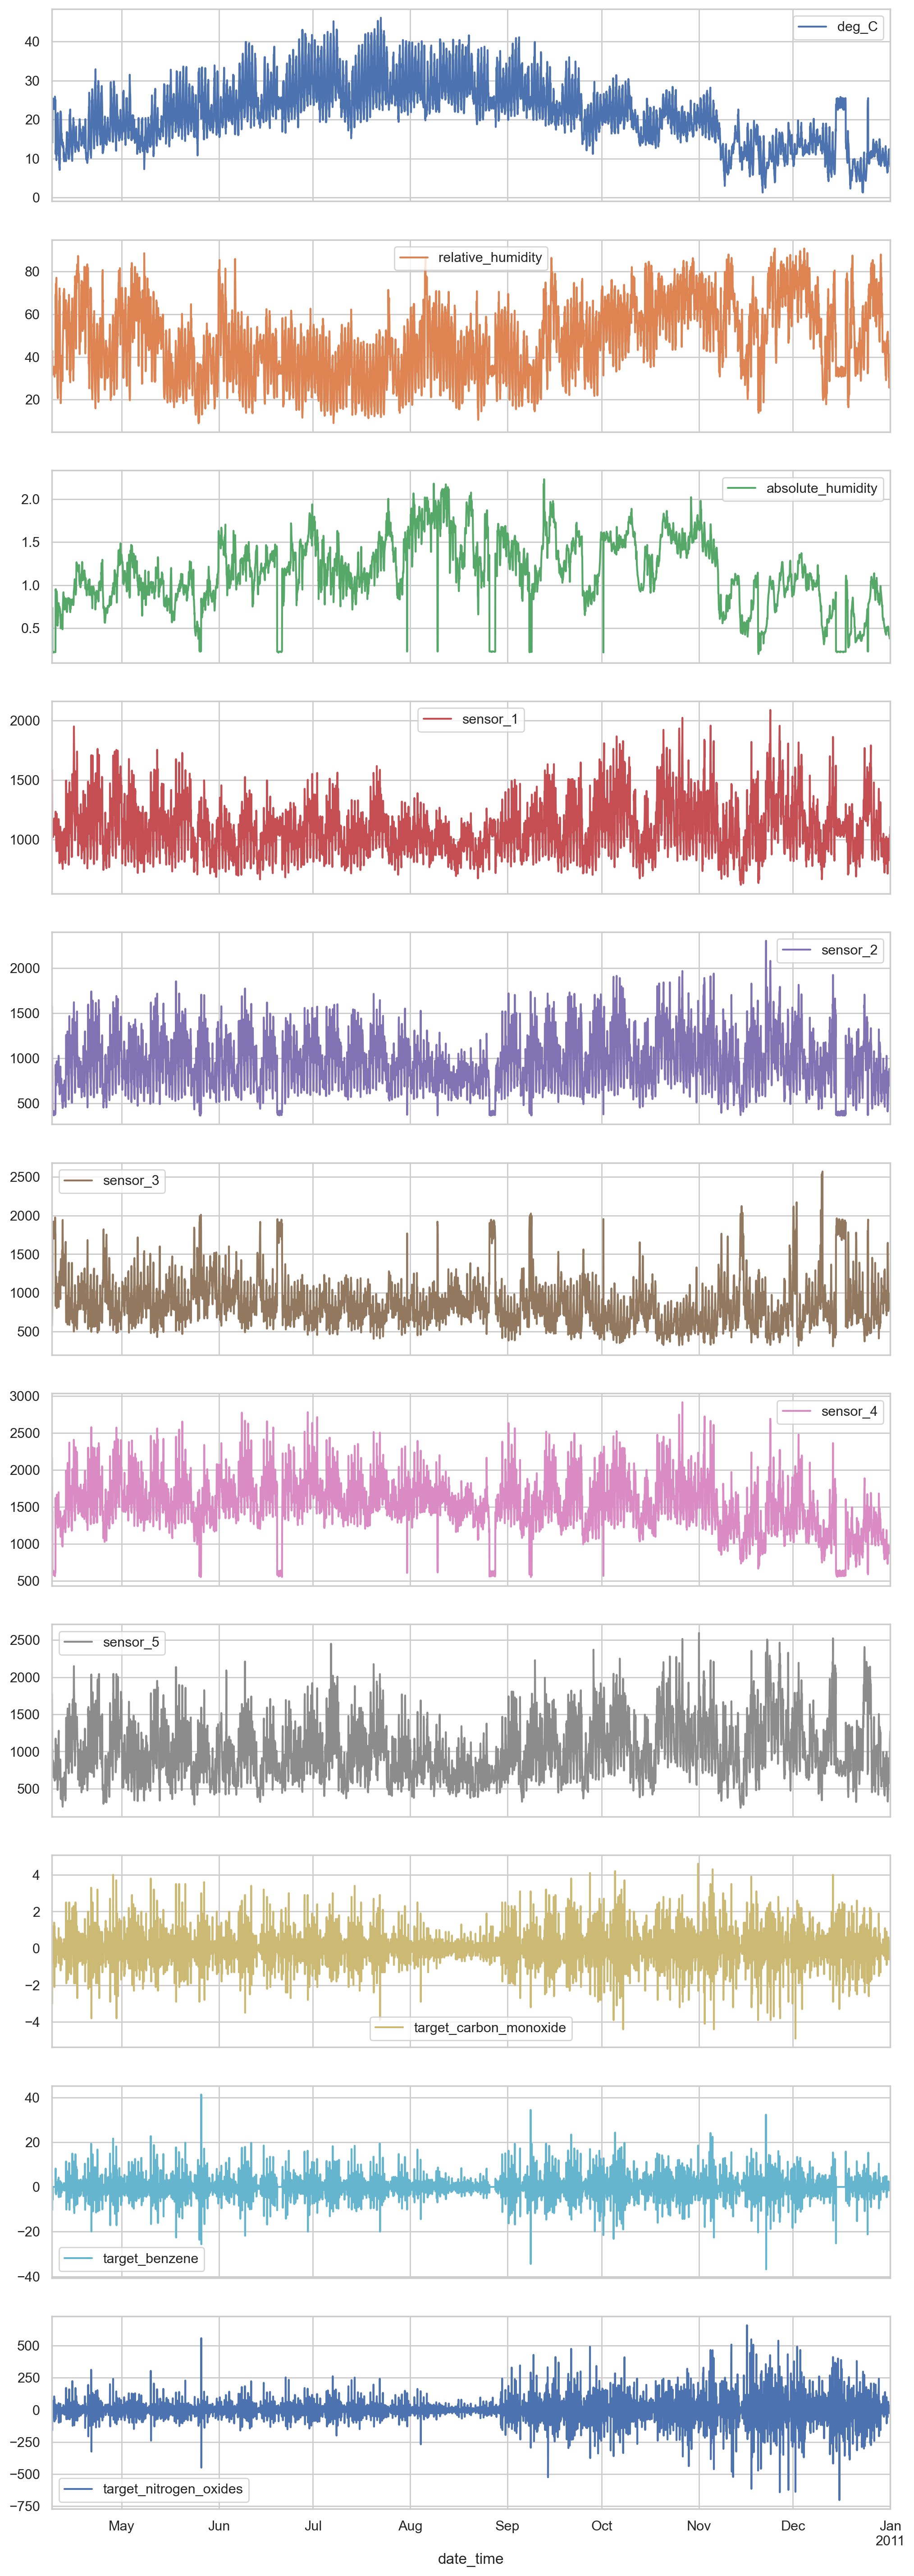

In [3]:
df[features + targets].plot(subplots=True, figsize=(12, 36))


There are 3 periods that should be omitted

## Temporal features analysis
Immagino che il giorno della settimana e l'ora del giorno siano features con una grossa influenza sulle concentrazioni.
Indago:

In [4]:
day_type = pd.CategoricalDtype(list(day_name), ordered=True)
df["weekday"] = df.index.day_name().astype(day_type)
df["week"] = df.index.isocalendar().week.astype("int")
df["hour"] = df.index.hour
df["day"] = df.index.day_of_year
df["season"] = df.index.quarter.map(
    {1: "Winter", 2: "Spring", 3: "Summer", 4: "Autumn"})


In [5]:
def seasonal_plot(X, y, freq, sep, ax=None, **kwargs):
    return sns.lineplot(
        data=X,
        x=freq,
        y=y,
        hue=sep,
        estimator="median",
        errorbar=("pi", 90),
        ax=ax,
        **kwargs
    )


<Axes: xlabel='hour', ylabel='target_carbon_monoxide'>

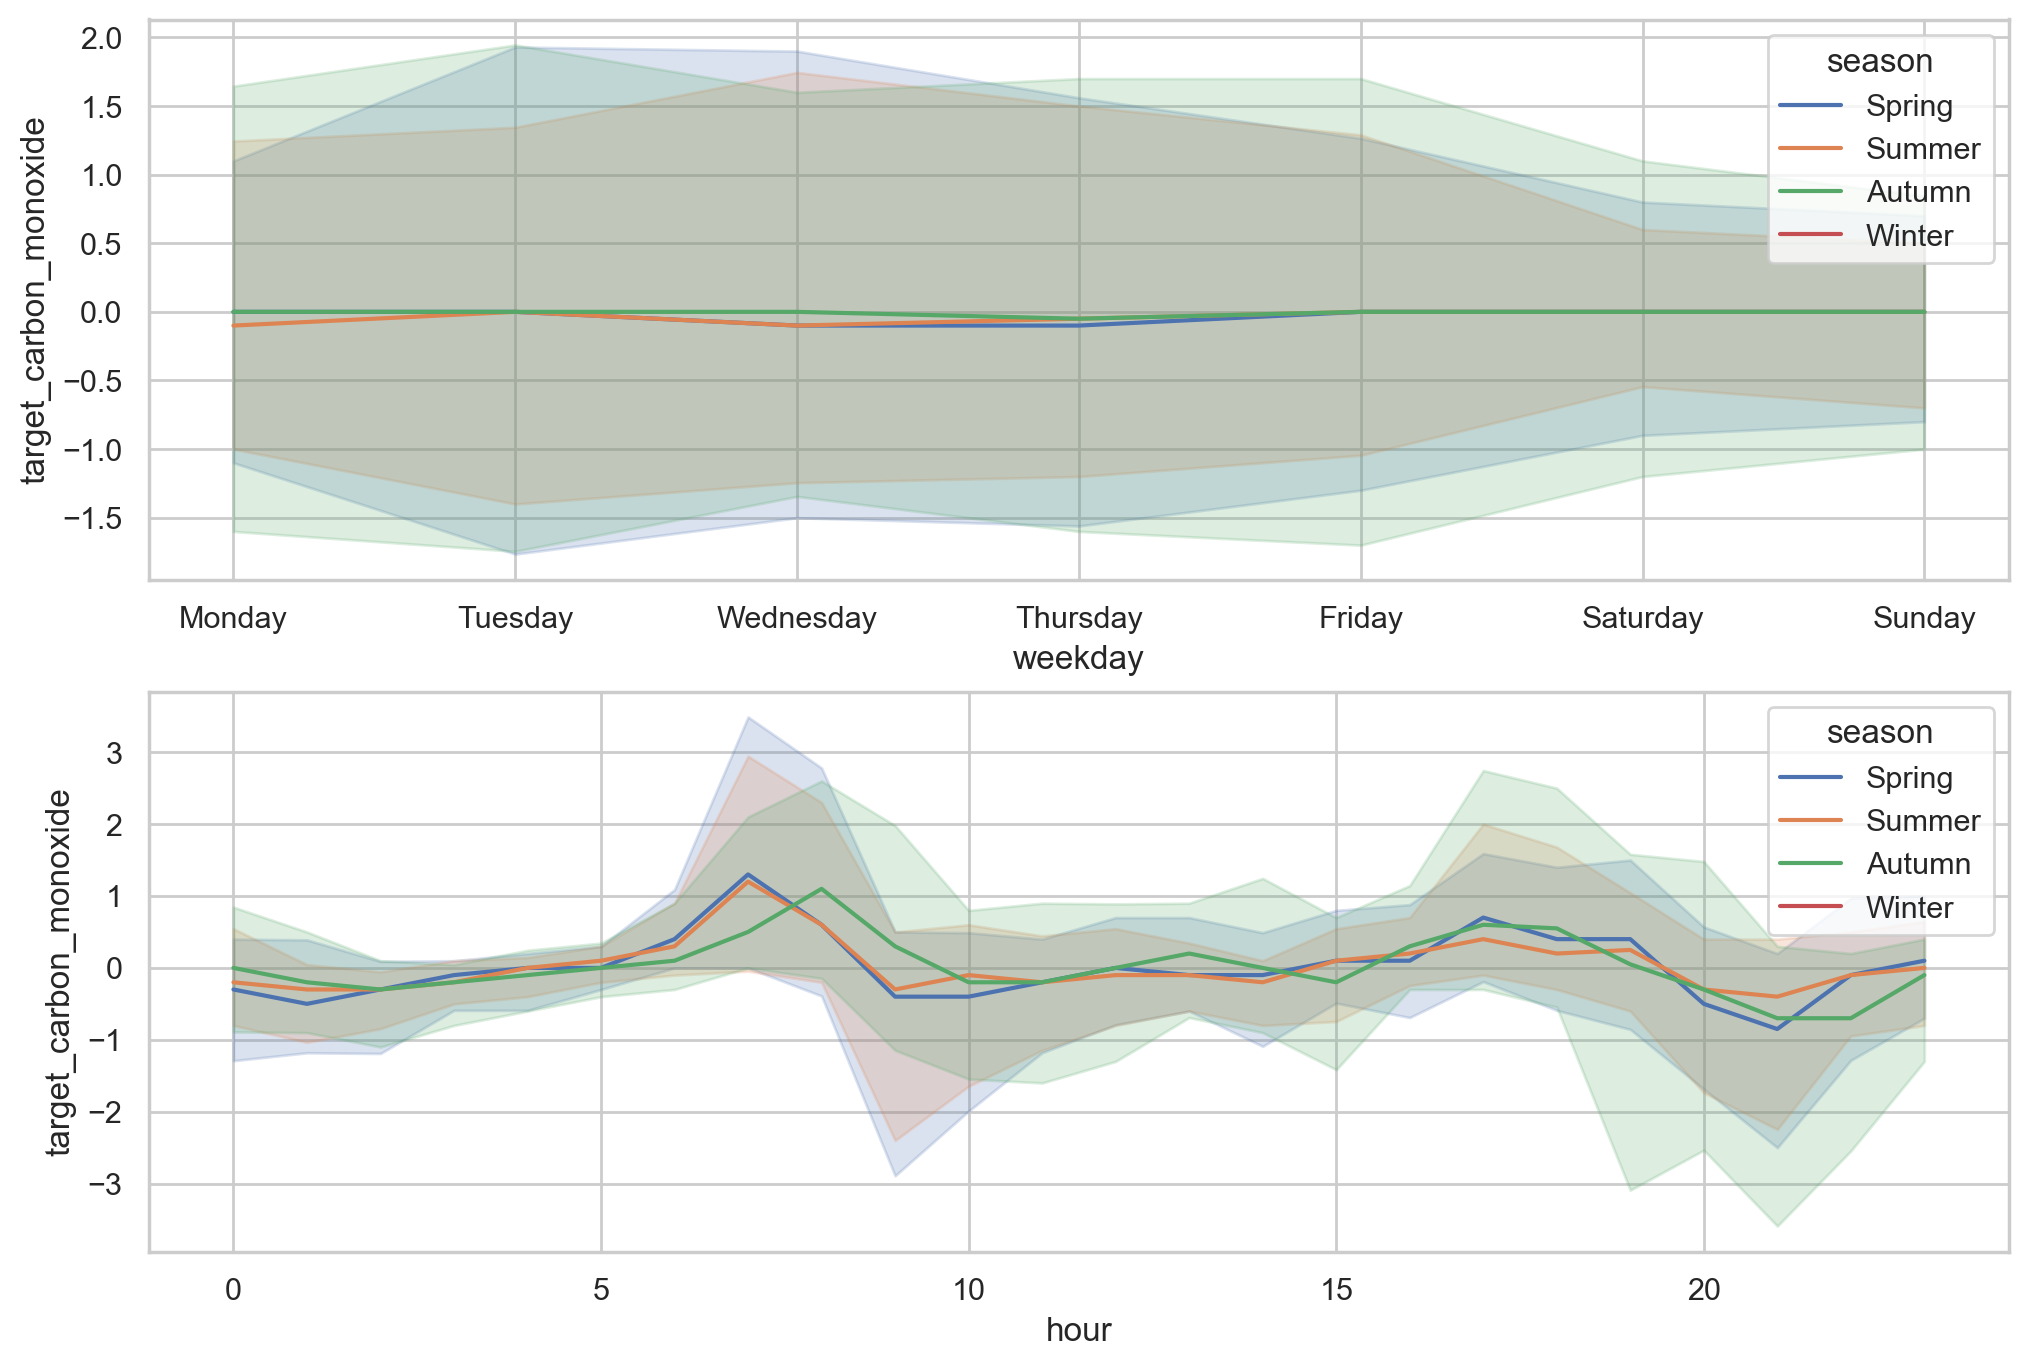

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
seasonal_plot(df.to_period("H"),
              y=targets[0], freq="weekday", sep="season", ax=axes[0])
seasonal_plot(df.to_period("H"),
              y=targets[0], freq="hour", sep="season", ax=axes[1])


<Axes: xlabel='hour', ylabel='target_benzene'>

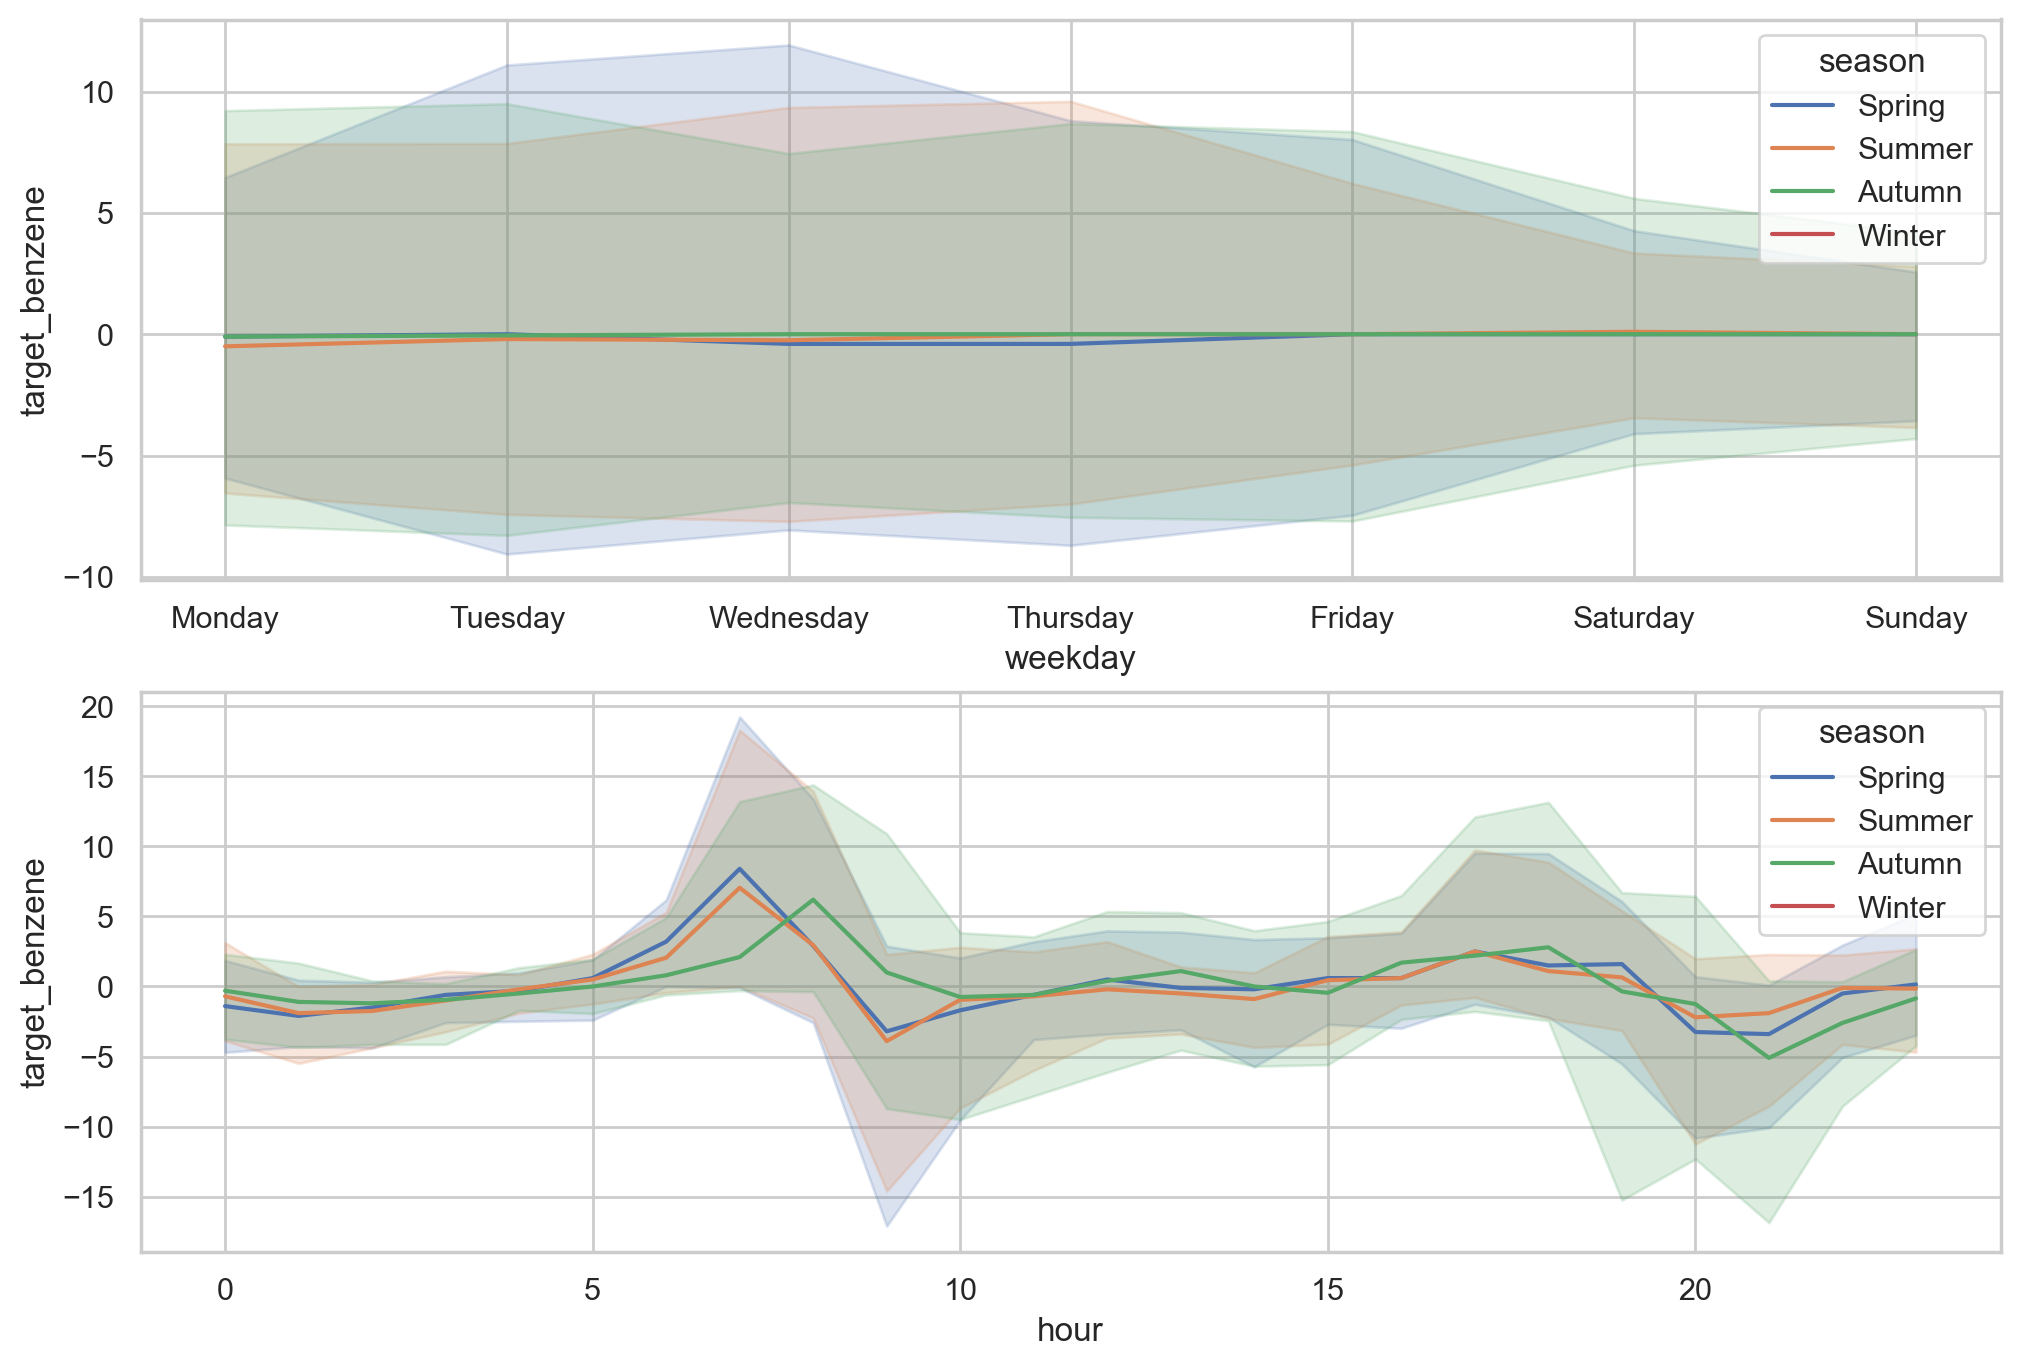

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
seasonal_plot(df.to_period("H"),
              y=targets[1], freq="weekday", sep="season", ax=axes[0])
seasonal_plot(df.to_period("H"),
              y=targets[1], freq="hour", sep="season", ax=axes[1])


<Axes: xlabel='hour', ylabel='target_nitrogen_oxides'>

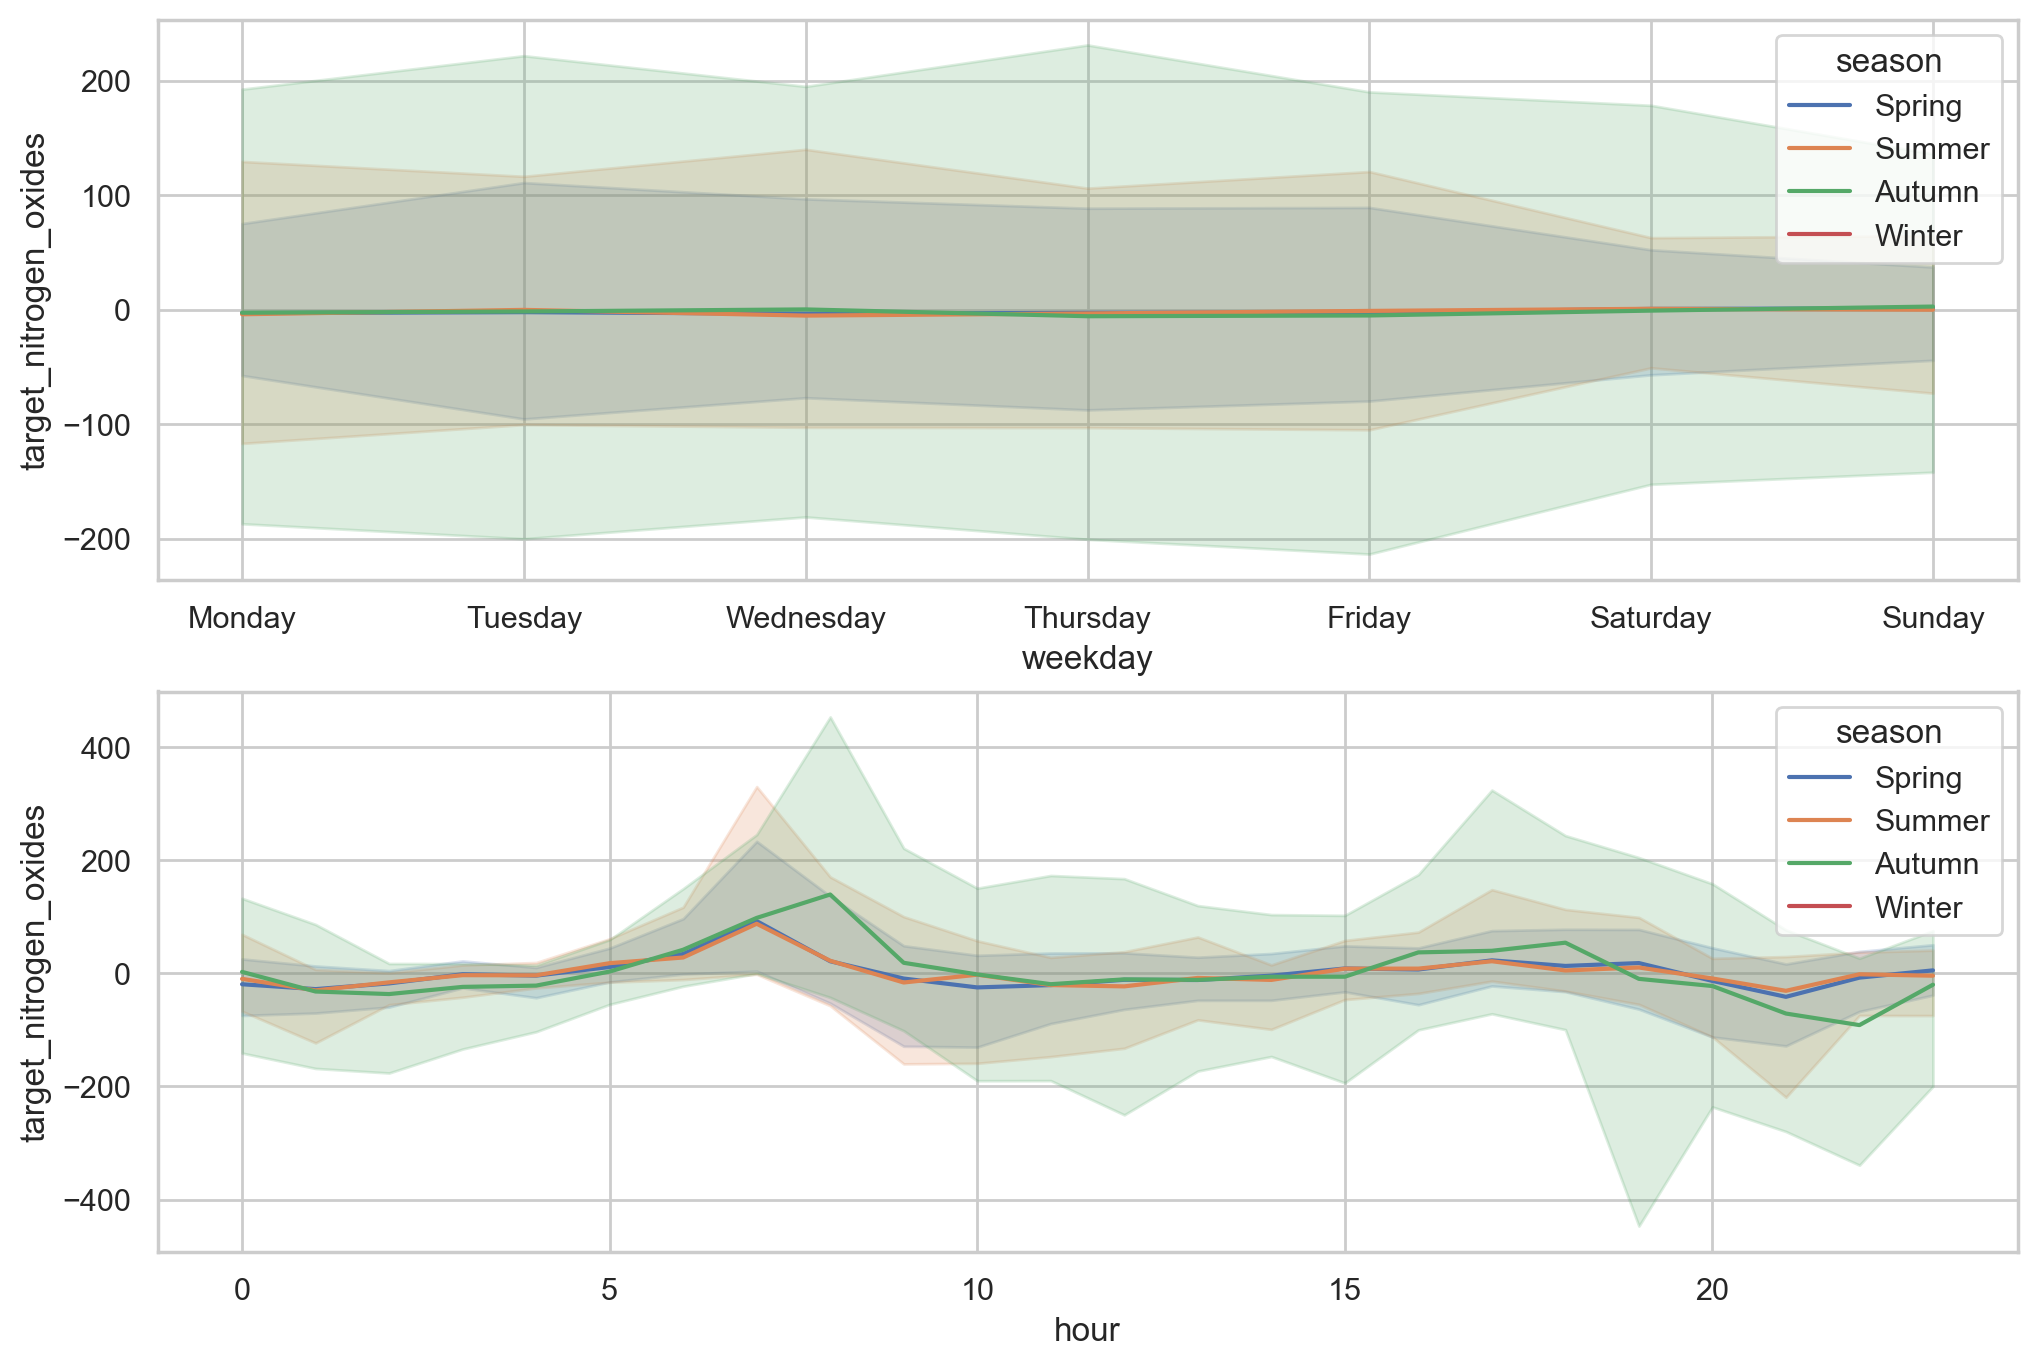

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
seasonal_plot(df.to_period("H"),
              y=targets[2], freq="weekday", sep="season", ax=axes[0])
seasonal_plot(df.to_period("H"),
              y=targets[2], freq="hour", sep="season", ax=axes[1])


Weak dependence on the weekday, strong dependence on the hour. Similar trends across all targets. Different behaviours depending on seasons.

Time features to extract:
- hour of day;
- weekday (feature);
- season (feature);

In [9]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1H")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 12, 26, 52, 104, 365, 730, 365*4])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
            "Daily (365)",
            "Twice a day (730)",
            f"Four times a day ({365*4})"
        ],
        rotation=30,
        ha="right"
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    if ts.name:
        ax.set_title(ts.name)
    return ax


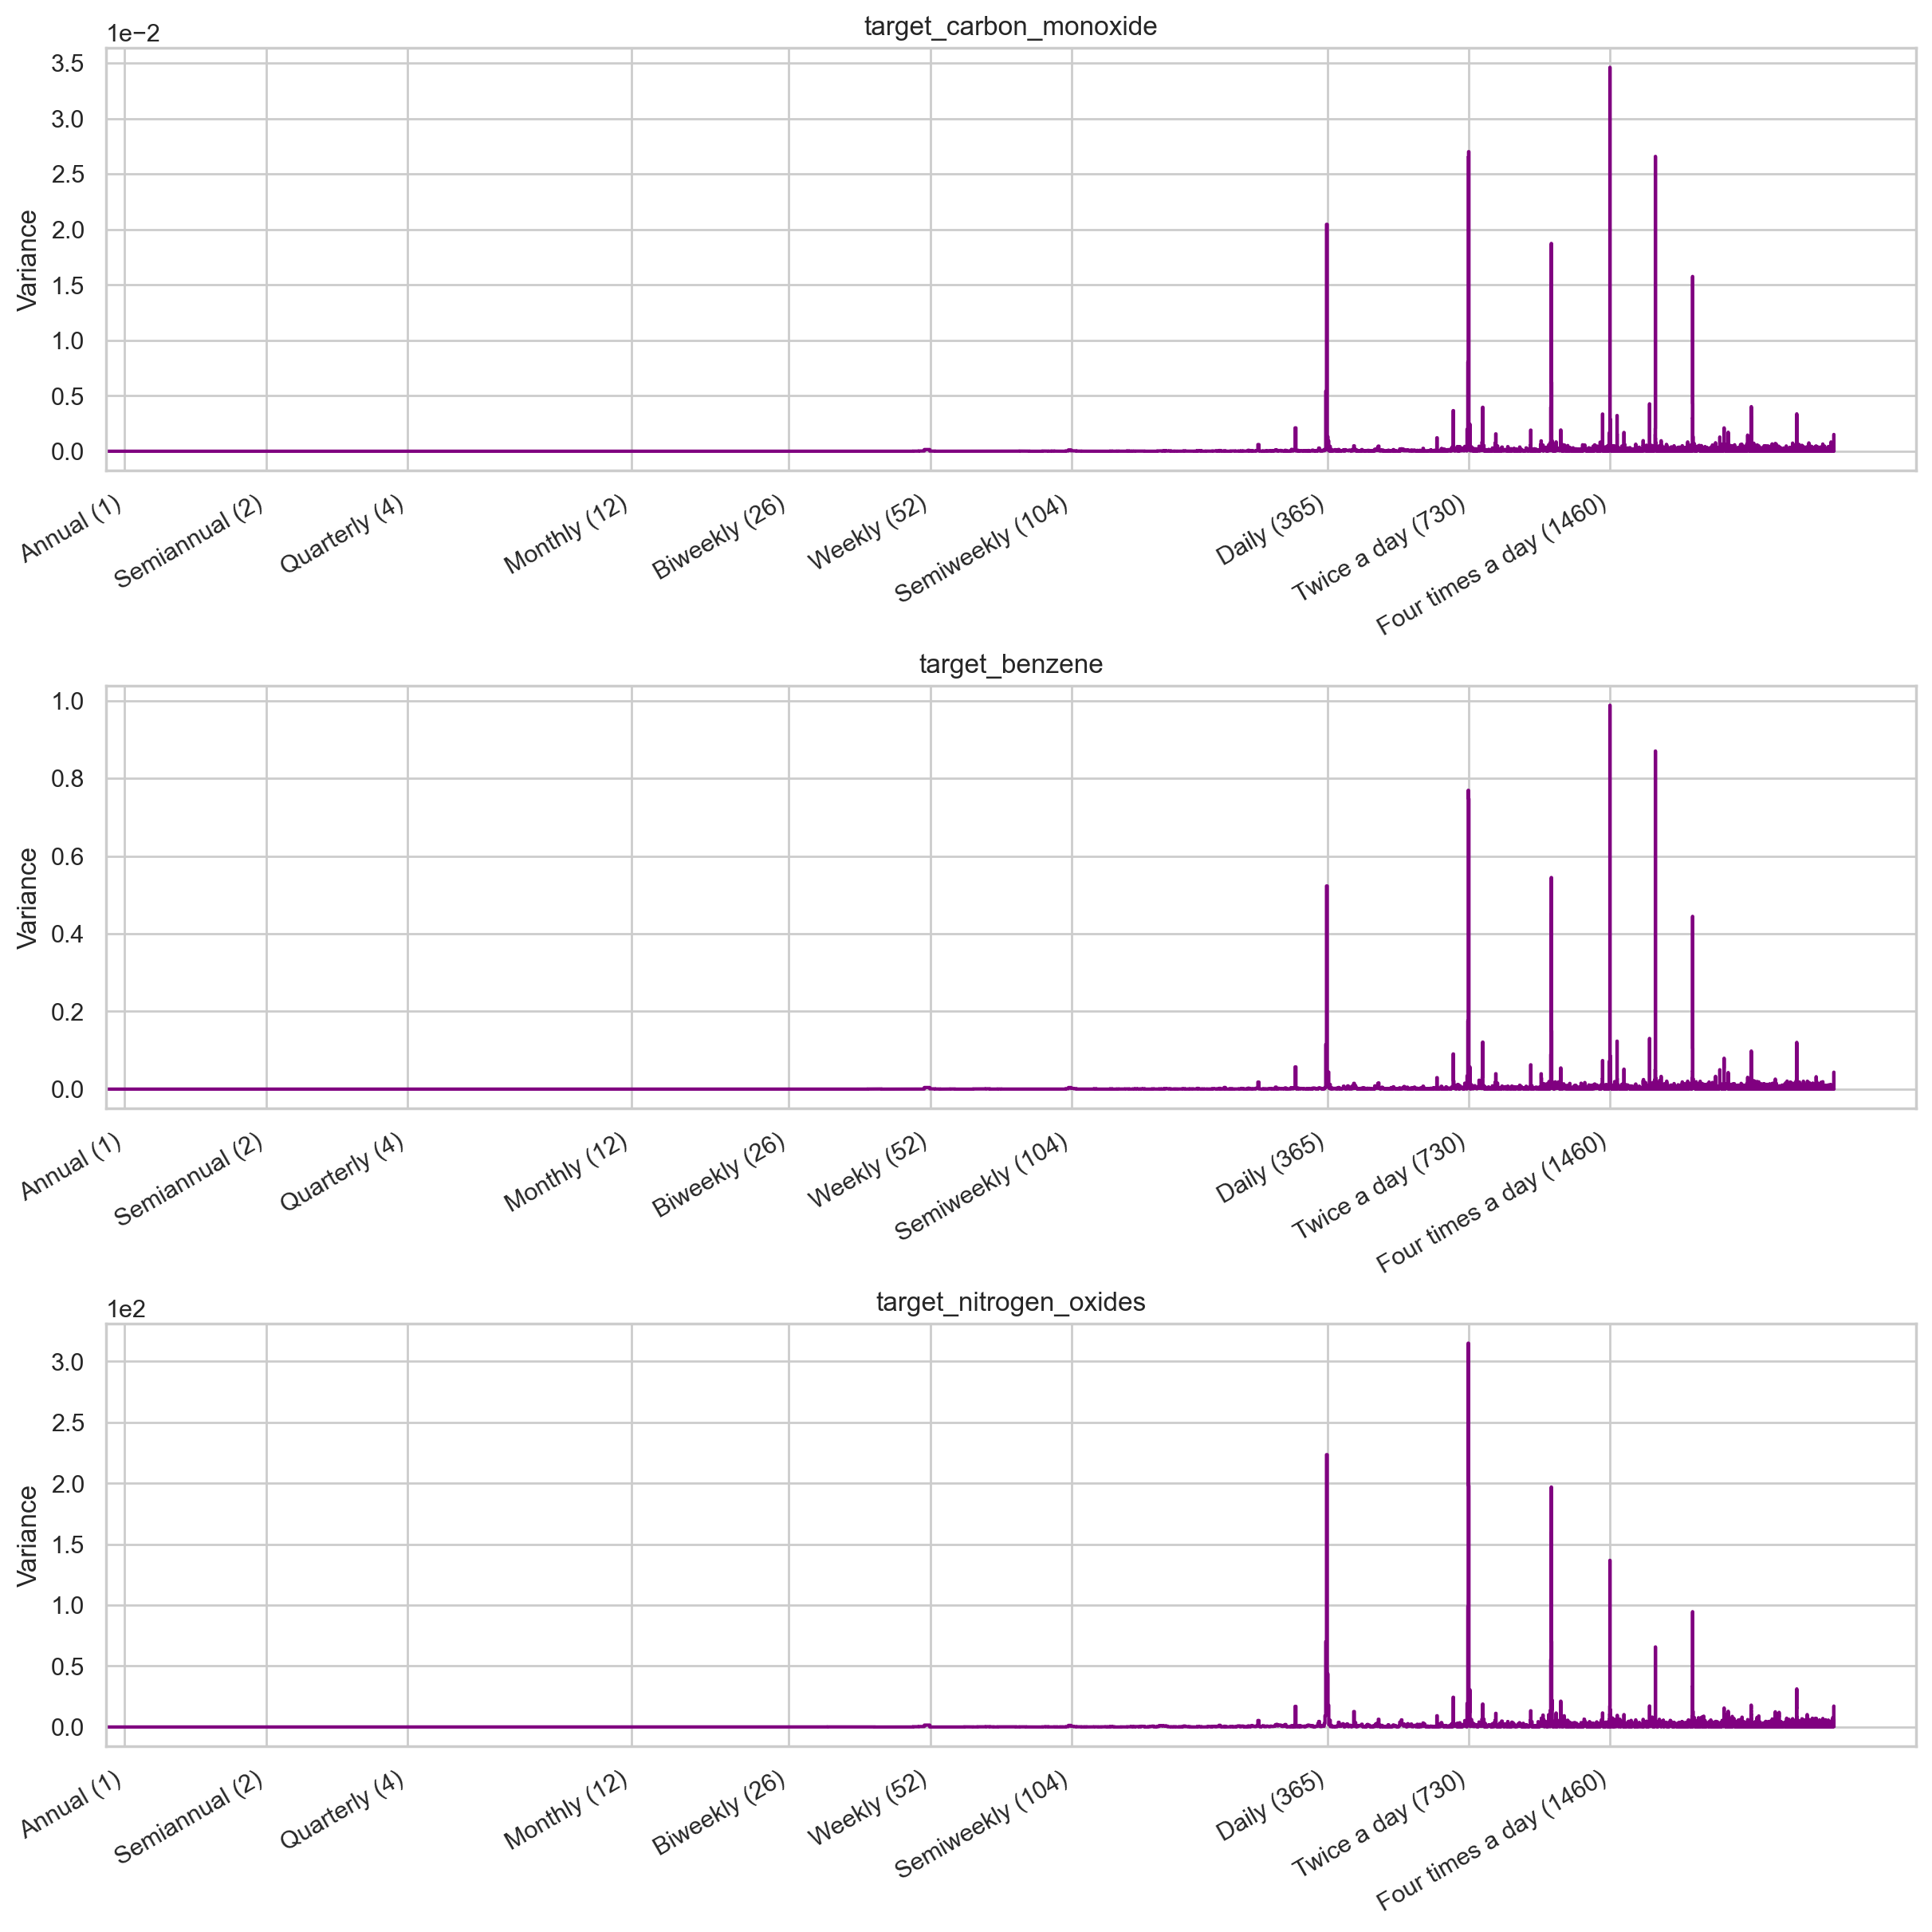

In [10]:
_, axes = plt.subplots(3, figsize=(12, 12), constrained_layout=True)
for ax, target in zip(axes, targets):
    plot_periodogram(df[target], detrend=None, ax=ax)
    # ax.set_yscale("log")


In [11]:
in_day_features = CalendarFourier("D", 8)
# in_year_features = CalendarSeasonality("M", "A")
# in_week_features = CalendarSeasonality("D", "W")
time_features = DeterministicProcess(
    df.to_period().index,
    constant=True,
    additional_terms=[in_day_features],
    drop=True
)
X_periodic = time_features.in_sample()
y = df[targets]


In [12]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X_periodic, y)


In [13]:
y_pred = model.predict(X_periodic)


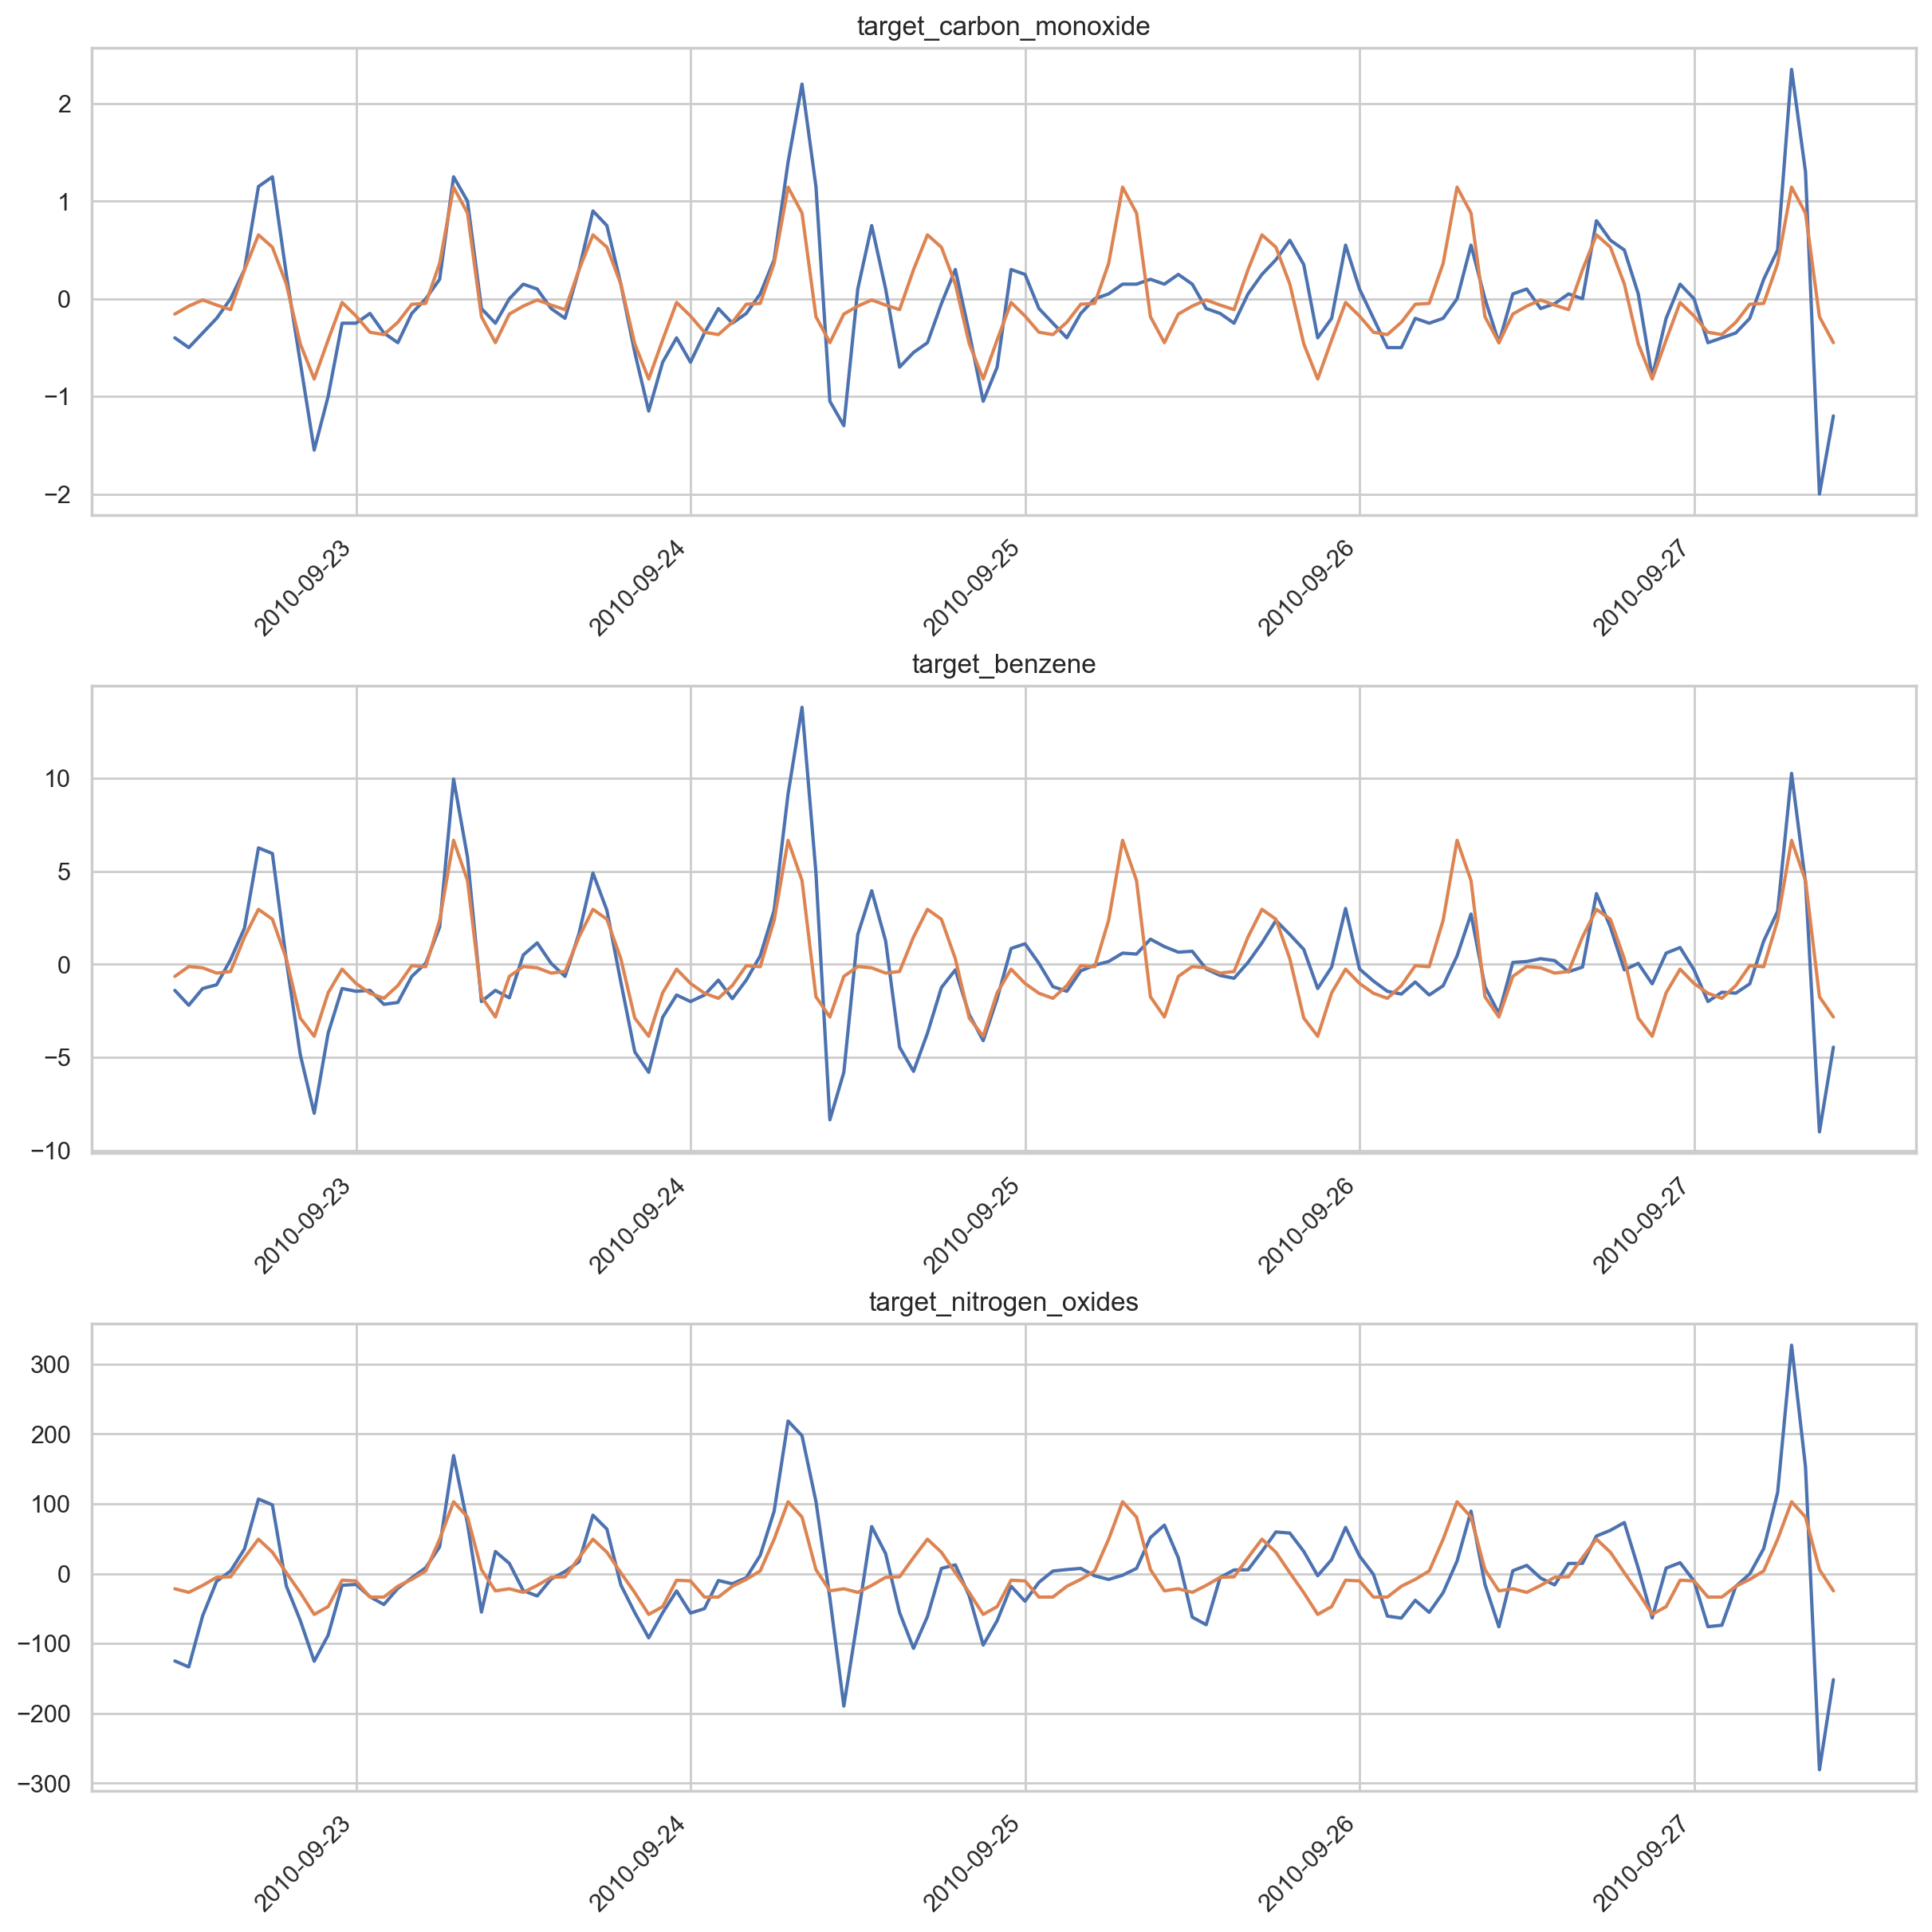

In [14]:
def plot_baseline(X, y_target, y_predicted, days, target, ax: plt.Axes):
    ax.plot(X.index, y_target.rolling(int(days*24),
            min_periods=int(days*12), center=True).mean().to_numpy()[:, target])
    ax.plot(X.index, y_predicted[:, target])
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(),
                  rotation=45, ha='right')


fig, axes = plt.subplots(3, 1, figsize=(12, 12), constrained_layout=True)
for ax, (i, target) in zip(axes, enumerate(targets)):
    plot_baseline(X_periodic.iloc[4000:4000+24*5].to_timestamp(),
                  y.iloc[4000:4000+24*5], y_pred[4000:4000+24*5], 1/12, i, ax)
    ax.set_title(target)


In [15]:
y_detrend = y - y_pred


<Axes: title={'center': 'target_nitrogen_oxides'}, ylabel='Variance'>

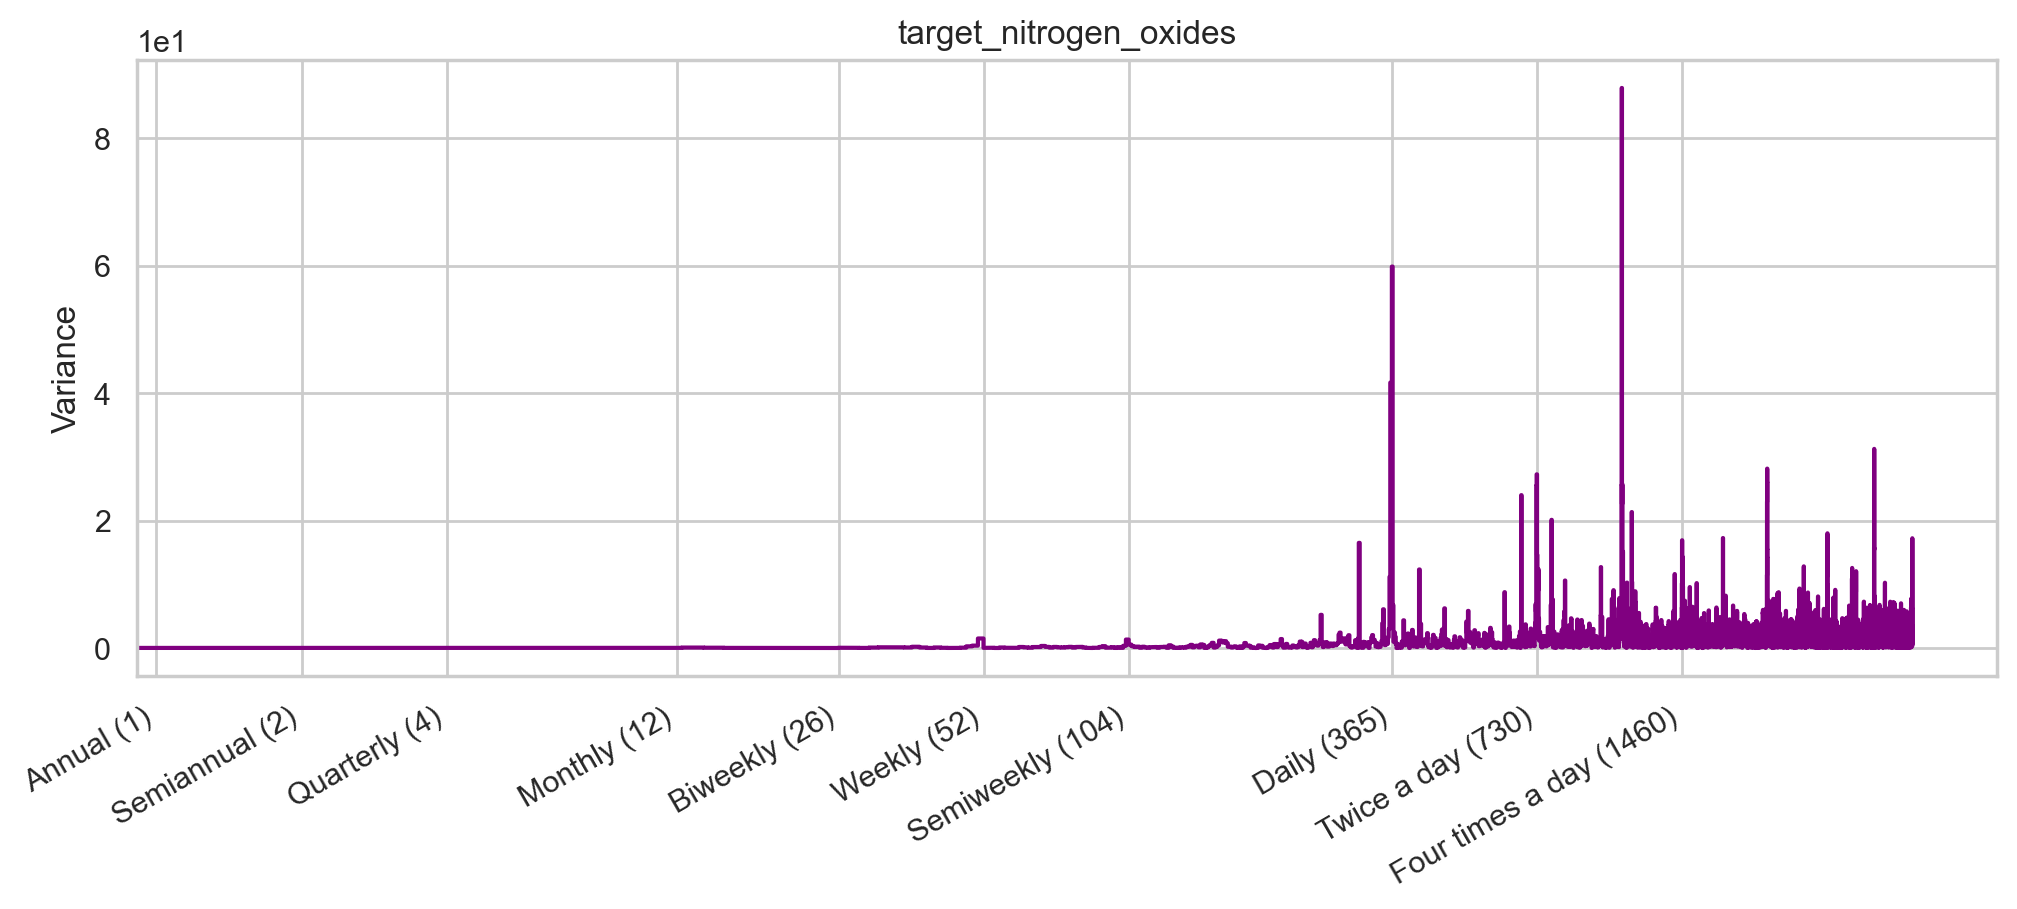

In [16]:
_, ax = plt.subplots(figsize=(12, 4))
plot_periodogram(y_detrend[targets[2]], detrend=None, ax=ax)
# ax.set_yscale("log")
# ax.set_ylim(1e-4, 1e6)


In [17]:
from lib.models import PollutionEstimator
from lib.models.forecast import PollutionLSTM

compilation_kwargs = {"loss": "mse"}
with tf.device("/CPU:0"):
    model = PollutionLSTM(features, targets, 128,
                          input_days=7, output_days=1 / 24)
    estimator = PollutionEstimator(features, targets, input_days=model.input_days, output_days=model.output_days,
                                   offset_hours=model.offset_hours, shift_hours=model.shift_hours, pollution_model=model, compilation_kwargs=compilation_kwargs)
    estimator.compile(**compilation_kwargs)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-31 12:21:57.763352: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-31 12:21:57.763378: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
new_df = df[features].join(pd.DataFrame(y_detrend, columns=targets))


In [19]:
with tf.device("/CPU:0"):
    estimator.train(new_df, epochs=30, validation_data=val_df, train_split=None, callbacks=[
        TB("../logs/detrended"), ES(patience=30, restore_best_weights=True)])


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-03-31 12:21:58.054842: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/30
      2/Unknown - 2s 67ms/step - loss: 2612.9312

2023-03-31 12:22:02.873698: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x288123c70 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-03-31 12:22:02.873715: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
2023-03-31 12:22:02.876598: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-31 12:22:02.892492: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


196/196 [==============================] - 16s 69ms/step - loss: 1832.4448 - val_loss: 875.4631
Epoch 2/30
196/196 [==============================] - 18s 85ms/step - loss: 1365.1949 - val_loss: 392.6079
Epoch 3/30
196/196 [==============================] - 17s 78ms/step - loss: 1232.7906 - val_loss: 387.5616
Epoch 4/30
196/196 [==============================] - 17s 83ms/step - loss: 1155.3419 - val_loss: 521.5507
Epoch 5/30
196/196 [==============================] - 16s 77ms/step - loss: 1101.8608 - val_loss: 530.1829
Epoch 6/30
196/196 [==============================] - 17s 79ms/step - loss: 1077.4551 - val_loss: 502.1290
Epoch 7/30
196/196 [==============================] - 17s 83ms/step - loss: 1029.2721 - val_loss: 556.8237
Epoch 8/30
196/196 [==============================] - 17s 80ms/step - loss: 1002.3532 - val_loss: 526.1594
Epoch 9/30
196/196 [==============================] - 18s 87ms/step - loss: 980.4669 - val_loss: 544.1754
Epoch 10/30
196/196 [============================